In [113]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pickle
import re
from sklearn.preprocessing import StandardScaler

In [114]:
# Load the CSV file
file_path = "CVEfixes.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Preview the data
print(data.head())

                                commit_hash  \
0  2864e767053317538feafa815046fff89e5a16be   
1  2864e767053317538feafa815046fff89e5a16be   
2  2864e767053317538feafa815046fff89e5a16be   
3  2864e767053317538feafa815046fff89e5a16be   
4  2864e767053317538feafa815046fff89e5a16be   

                                      commit_message  num_lines_added  \
0  Update.\n\n1999-11-09  Ulrich Drepper  <dreppe...              450   
1  Update.\n\n1999-11-09  Ulrich Drepper  <dreppe...              450   
2  Update.\n\n1999-11-09  Ulrich Drepper  <dreppe...              450   
3  Update.\n\n1999-11-09  Ulrich Drepper  <dreppe...              450   
4  Update.\n\n1999-11-09  Ulrich Drepper  <dreppe...              450   

   num_lines_deleted  dmm_unit_complexity  dmm_unit_size     filename  \
0                326                  1.0       0.371429    ChangeLog   
1                326                  1.0       0.371429     Makefile   
2                326                  1.0       0.371429   

In [115]:
def count_rows(data):
    """
    Count the number of rows in the dataset.
    """
    return data.shape[0]  # shape[0] gives the number of rows

if data is not None:
    total_rows = count_rows(data)
    print(f"Total number of rows in the dataset: {total_rows}")


Total number of rows in the dataset: 62786


In [116]:
def preprocess_data(data):
    """
    Preprocess the dataset:
    - Replace NaN in severity with 'LOW' (non-vulnerable)
    - Map severity to binary labels: 0 (non-vulnerable), 1 (vulnerable)
    - Ensure that NaN and LOW severity rows are under the non-vulnerable class (0)
    """
    # Replace NaN severity values with 'LOW'
    data.loc[:, 'severity'] = data['severity'].fillna('LOW')

    # Map severity to binary labels
    severity_mapping = {'LOW': 0, 'MEDIUM': 1, 'HIGH': 1}
    data.loc[:, 'vulnerable'] = data['severity'].map(severity_mapping)

    # Replace NaN in file_complexity with 0
    data.loc[:, 'file_complexity'] = data['file_complexity'].fillna(0)

    # Log the class distribution after preprocessing
    print("Class distribution after preprocessing:")
    print(data['vulnerable'].value_counts())
    
    return data

In [117]:
if data is not None:
    data = preprocess_data(data)
    print("Updated class distribution:")
    print(data['vulnerable'].value_counts())


Class distribution after preprocessing:
vulnerable
1    31540
0    31246
Name: count, dtype: int64
Updated class distribution:
vulnerable
1    31540
0    31246
Name: count, dtype: int64


In [118]:
def extract_vulnerability_features(row):
    """
    Extract features from the file_diff column to detect various vulnerability patterns.
    """
    file_diff = row.get('file_diff', '')

    return {
        # SQL Injection
        "contains_sql_keywords": bool(re.search(r"\b(SELECT|INSERT|UPDATE|DELETE|WHERE|FROM|DROP|CREATE|EXECUTE)\b", file_diff, re.IGNORECASE)),

        # Command Injection
        "contains_command_injection": bool(re.search(r"\b(os\.system|subprocess\.call|subprocess\.Popen)\b", file_diff)),

        # Unsafe Deserialization
        "contains_unsafe_deserialization": bool(re.search(r"\b(pickle\.load|yaml\.load)\b", file_diff)),

        # Hardcoded Credentials
        "contains_hardcoded_credentials": bool(re.search(r"\b(password|passwd|key|secret|token)\b.*[=:].*['\"]", file_diff, re.IGNORECASE)),

        # Insecure Cryptographic Practices
        "contains_insecure_crypto": bool(re.search(r"\b(md5|sha1|des|rc4|base64\.decode)\b", file_diff, re.IGNORECASE)),

        # Buffer Overflow
        "contains_buffer_operations": bool(re.search(r"\b(strcpy|strcat|gets|scanf|memcpy)\b", file_diff)),

        # Path Traversal
        "contains_path_traversal": bool(re.search(r"(\.\.\\|\.\./|os\.path\.join|os\.open)", file_diff)),

        # Cross-Site Scripting (XSS)
        "contains_xss_patterns": bool(re.search(r"(<script>|document\.write|innerHTML|eval|alert)", file_diff, re.IGNORECASE)),
    }

# Apply the function to each row of the dataset
new_features = data.apply(extract_vulnerability_features, axis=1, result_type='expand')

# Add the extracted features to the dataset
data = pd.concat([data, new_features], axis=1)

# Preview the updated dataset
display((data.head()))

,commit_hash,commit_message,num_lines_added,num_lines_deleted,dmm_unit_complexity,dmm_unit_size,filename,file_diff,code_before,code_after,...,cwe_description,vulnerable,contains_sql_keywords,contains_command_injection,contains_unsafe_deserialization,contains_hardcoded_credentials,contains_insecure_crypto,contains_buffer_operations,contains_path_traversal,contains_xss_patterns
0,2864e767053317538feafa815046fff89e5a16be,Update.\n\n1999-11-09 Ulrich Drepper <dreppe...,450,326,1.0,0.371429,ChangeLog,"@@ -1,3 +1,55 @@\n+1999-11-09 Ulrich Drepper ...",1999-11-08 Ulrich Drepper <drepper@cygnus.co...,1999-11-09 Ulrich Drepper <drepper@cygnus.co...,...,The product does not check the return value fr...,1,True,False,False,False,False,False,False,False
1,2864e767053317538feafa815046fff89e5a16be,Update.\n\n1999-11-09 Ulrich Drepper <dreppe...,450,326,1.0,0.371429,Makefile,"@@ -57,7 +57,7 @@ include ../Makeconfig\n \n a...","# Copyright (C) 1991,92,93,94,95,96,97,98,99 F...","# Copyright (C) 1991,92,93,94,95,96,97,98,99 F...",...,The product does not check the return value fr...,1,False,False,False,False,False,False,True,False
2,2864e767053317538feafa815046fff89e5a16be,Update.\n\n1999-11-09 Ulrich Drepper <dreppe...,450,326,1.0,0.371429,africa,"@@ -1,4 +1,4 @@\n-# @(#)africa\t7.31\n+# @(#)a...",# @(#)africa\t7.31\n\n# This data is by no mea...,# @(#)africa\t7.32\n\n# This data is by no mea...,...,The product does not check the return value fr...,1,True,False,False,False,False,False,False,False
3,2864e767053317538feafa815046fff89e5a16be,Update.\n\n1999-11-09 Ulrich Drepper <dreppe...,450,326,1.0,0.371429,asia,"@@ -1,4 +1,4 @@\n-# @(#)asia\t7.48\n+# @(#)asi...",# @(#)asia\t7.48\n\n# This data is by no means...,# @(#)asia\t7.49\n\n# This data is by no means...,...,The product does not check the return value fr...,1,True,False,False,False,False,False,False,False
4,2864e767053317538feafa815046fff89e5a16be,Update.\n\n1999-11-09 Ulrich Drepper <dreppe...,450,326,1.0,0.371429,australasia,"@@ -1,4 +1,4 @@\n-# @(#)australasia\t7.51\n+# ...",# @(#)australasia\t7.51\n# This file also incl...,# @(#)australasia\t7.52\n# This file also incl...,...,The product does not check the return value fr...,1,True,False,False,False,False,False,False,False


In [119]:
from sklearn.utils import resample

# Balance the dataset
vulnerable = data[data['vulnerable'] == 1]
non_vulnerable = data[data['vulnerable'] == 0]

# Oversample vulnerable examples
vulnerable_upsampled = resample(vulnerable,
                                replace=True,
                                n_samples=len(non_vulnerable),
                                random_state=42)

# Combine the datasets
data_balanced = pd.concat([non_vulnerable, vulnerable_upsampled])

In [120]:
def split_data(data):
    """
    Split the data into training and testing sets.
    """
    # Updated feature set
    X = data[['cvss3_base_score', 'num_lines_added', 'num_lines_deleted', 'file_complexity',
          'contains_sql_keywords', 'contains_command_injection', 'contains_unsafe_deserialization',
          'contains_hardcoded_credentials', 'contains_insecure_crypto',
          'contains_buffer_operations', 'contains_path_traversal', 'contains_xss_patterns']]

    # Target variable
    y = data['vulnerable']


    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Data split into training and testing sets.")
    print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
    return X_train, X_test, y_train, y_test

# Split the data
X_train, X_test, y_train, y_test = split_data(data)

Data split into training and testing sets.
Training samples: 50228, Testing samples: 12558


In [121]:
def tune_random_forest(X_train, y_train):
    """
    Perform hyperparameter tuning for Random Forest using GridSearchCV.
    """
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }

    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Best Hyperparameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)
    return grid_search.best_estimator_

# Tune the Random Forest model
best_rf_model = tune_random_forest(X_train, y_train)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.8780361764406797


Model Evaluation Results:
Accuracy: 0.8881987577639752
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      6239
           1       0.88      0.90      0.89      6319

    accuracy                           0.89     12558
   macro avg       0.89      0.89      0.89     12558
weighted avg       0.89      0.89      0.89     12558

Confusion Matrix:
[[5463  776]
 [ 628 5691]]


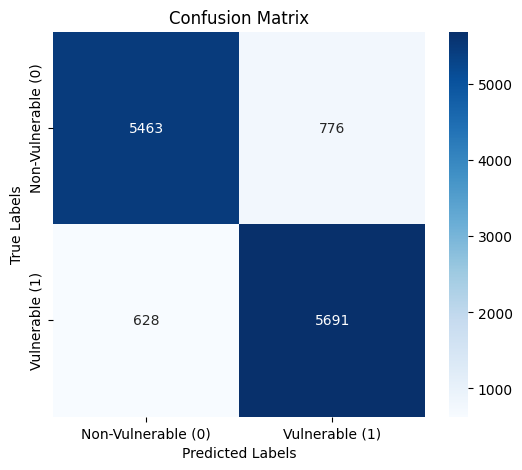

In [122]:
def evaluate_model_with_confusion_matrix(model, X_test, y_test):
    """
    Evaluate the trained model on the test dataset with a confusion matrix.
    """
    # Make predictions
    y_pred = model.predict(X_test)

    # Accuracy and classification report
    print("Model Evaluation Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Visualize the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Vulnerable (0)", "Vulnerable (1)"], yticklabels=["Non-Vulnerable (0)", "Vulnerable (1)"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate the model with confusion matrix
evaluate_model_with_confusion_matrix(best_rf_model, X_test, y_test)


In [123]:
def save_model(model, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved as '{file_name}'")

if __name__ == "__main__":
    save_model(best_rf_model, 'trained_model.pkl')

Model saved as 'trained_model.pkl'
